In [1]:
print("Hello World")

Hello World


In [2]:
import pandas as pd
import numpy as np

# Generating random data
np.random.seed(0)
num_rows = 20
data = {
    'temperature': np.random.randint(20, 30, num_rows),
    'humidity': np.random.randint(40, 60, num_rows)
}
print(data)
# Generating random time indices
# Generating random time offsets for each row
time_offsets = np.random.randint(0, 120, num_rows)
time_offsets = pd.to_timedelta(time_offsets, unit='s')

# Generating random start and end times
start_time = pd.Timestamp('2024-02-24 9:57:37')
end_time = pd.Timestamp('2024-02-24 11:00:00')

# Generating time indices for each row
time_indices = [start_time + pd.Timedelta(minutes=2*i) + offset for i, offset in enumerate(time_offsets)]

print(time_indices)
# Creating DataFrame
combined_data = pd.DataFrame(data, time_indices)
# combined_data.reset_index(drop=True, inplace=True)
# Find the timestamp of the first row
first_timestamp = combined_data.index[0]
last_timestamp = combined_data.index[-1]

# Round down the timestamp to the nearest round minute in the past
# rounded_timestamp = first_timestamp.floor('min')
# rounded_last_timestamp = last_timestamp.floor('min')


# Update the index of the first row with the rounded timestamp
# combined_data.index.values[0] = rounded_timestamp
# combined_data.index.values[-1] = rounded_last_timestamp

print("Random DataFrame:")
print(combined_data)


# Resample the data to 2-minute frequency
resampled_data = combined_data.resample('2min').bfill()

# Forward fill to ensure each timestamp has a value
# resampled_data = resampled_data.ffill()


print("\nResampled DataFrame:")
print(resampled_data)




{'temperature': array([25, 20, 23, 23, 27, 29, 23, 25, 22, 24, 27, 26, 28, 28, 21, 26, 27,
       27, 28, 21]), 'humidity': array([45, 53, 48, 49, 59, 56, 59, 45, 55, 55, 40, 58, 43, 57, 59, 59, 59,
       54, 47, 40])}
[Timestamp('2024-02-24 09:58:42'), Timestamp('2024-02-24 09:59:46'), Timestamp('2024-02-24 10:02:34'), Timestamp('2024-02-24 10:04:09'), Timestamp('2024-02-24 10:06:08'), Timestamp('2024-02-24 10:08:51'), Timestamp('2024-02-24 10:11:33'), Timestamp('2024-02-24 10:12:00'), Timestamp('2024-02-24 10:14:12'), Timestamp('2024-02-24 10:16:52'), Timestamp('2024-02-24 10:19:31'), Timestamp('2024-02-24 10:20:32'), Timestamp('2024-02-24 10:22:05'), Timestamp('2024-02-24 10:24:11'), Timestamp('2024-02-24 10:25:37'), Timestamp('2024-02-24 10:27:37'), Timestamp('2024-02-24 10:30:13'), Timestamp('2024-02-24 10:32:30'), Timestamp('2024-02-24 10:33:42'), Timestamp('2024-02-24 10:36:15')]
Random DataFrame:
                     temperature  humidity
2024-02-24 09:58:42           25      

In [3]:
from config import *
from DS import DempsterShafer
from process_data import DataProcessor
from datetime import datetime
import os
import time
import pandas as pd
import numpy as np

csv_file_dir = "data/20240316"
selected_headers = [
    "time_stamp",
    "group_id",
    "member_id",
    "id",
    "humidity",
    "temperature",
    "pm1.0_atm",
    "pm2.5_alt",
    "pm10.0_atm",
    "date_time_utc",
]
parameter_headers = [
    "humidity",
    "temperature",
    "pm1.0_atm",
    "pm2.5_alt",
    "pm10.0_atm",
]
csv_file_pattern = "20240316_UTS{}.csv"  # Replace with the pattern for your file names
data_processor = DataProcessor(csv_file_dir, csv_file_pattern, selected_headers)
csv_data = data_processor.process_files(start=1, end=5)
# print(csv_data)
# data_type = type(csv_data)
# print(data_type)

time_header = selected_headers[0]
measurement_pa = {}


csv_file_name_pattern = "20240316_UTS{}"
# Resample data from each sensor to 2-minute frequency
resampled_data = {}
for sensor_id, data in csv_data.items():
    # resampled_data[sensor_id] = data.resample('2T').mean()
    print(sensor_id)
    print(type(data))
    # print(data)

for sensor_order in range(1, num_sensors + 1):
    filename = csv_file_name_pattern.format(sensor_order)
    combined_data = csv_data[filename]
    # print("Combined Data", combined_data)
    # Convert the 'UTCDateTime' column to datetime format
    combined_data["date_time_utc"] = pd.to_datetime(combined_data["date_time_utc"])

    # Set 'UTCDateTime' as the index
    combined_data.set_index("date_time_utc", inplace=True)

    # Resample data to 2-minute frequency
    resampled_values = (
        combined_data[parameter_headers]
        .resample("2min")
        .bfill(limit=1)
        .round(3)
        .fillna(0)
    )
    # print("Resampled Values", resampled_values)
    print(combined_data.drop(parameter_headers, axis=1))
    concat_data = pd.concat(
        [
            combined_data.drop(parameter_headers, axis=1).resample("2min").bfill(),
            resampled_values,
        ],
        axis=1,
    )

    # Backward fill other columns
    resampled_data[filename] = concat_data
    output_file_path = rf"data\20240316\resampled_data{sensor_order}.csv"
    resampled_data[filename].to_csv(output_file_path)
indexes = [data.index for data in resampled_data.values()]
print("Indexes", indexes)
# print("\nA", resampled_data)
prepared_data = {
    key: resampled_data[key][parameter_headers].values for key in resampled_data
}
print(resampled_data)

20240316_UTS1
<class 'pandas.core.frame.DataFrame'>
20240316_UTS2
<class 'pandas.core.frame.DataFrame'>
20240316_UTS3
<class 'pandas.core.frame.DataFrame'>
20240316_UTS4
<class 'pandas.core.frame.DataFrame'>
                     time_stamp  group_id  member_id      id
date_time_utc                                               
2024-03-15 06:01:03  1710482463      1872     173213  173213
2024-03-15 06:03:03  1710482583      1872     173213  173213
2024-03-15 06:05:03  1710482703      1872     173213  173213
2024-03-15 06:07:03  1710482823      1872     173213  173213
2024-03-15 06:09:03  1710482943      1872     173213  173213
...                         ...       ...        ...     ...
2024-03-15 12:50:35  1710507035      1872     173213  173213
2024-03-15 12:52:35  1710507155      1872     173213  173213
2024-03-15 12:54:35  1710507275      1872     173213  173213
2024-03-15 12:56:35  1710507395      1872     173213  173213
2024-03-15 12:58:35  1710507515      1872     173213  173213

In [4]:
print("Prepared Data", prepared_data.values())

Prepared Data dict_values([array([[3.80e+01, 9.10e+01, 1.70e-01, 9.00e-01, 1.34e+00],
       [3.80e+01, 9.15e+01, 4.50e-02, 1.00e+00, 2.03e+00],
       [3.80e+01, 9.15e+01, 0.00e+00, 8.00e-01, 8.45e-01],
       ...,
       [3.30e+01, 9.10e+01, 9.50e-02, 9.00e-01, 7.95e-01],
       [3.30e+01, 9.10e+01, 1.10e-01, 1.00e+00, 7.75e-01],
       [3.30e+01, 9.10e+01, 1.05e-01, 8.00e-01, 6.90e-01]]), array([[3.500e+01, 9.150e+01, 1.000e-01, 1.000e+00, 1.305e+00],
       [3.400e+01, 9.200e+01, 2.000e-02, 1.000e+00, 1.050e+00],
       [3.400e+01, 9.250e+01, 0.000e+00, 9.000e-01, 1.210e+00],
       ...,
       [3.450e+01, 9.100e+01, 3.950e-01, 1.200e+00, 2.420e+00],
       [3.450e+01, 9.100e+01, 1.250e-01, 8.000e-01, 1.385e+00],
       [3.450e+01, 9.100e+01, 0.000e+00, 1.000e+00, 1.060e+00]]), array([[3.450e+01, 9.200e+01, 1.000e-02, 1.000e+00, 1.100e+00],
       [3.400e+01, 9.200e+01, 9.500e-02, 1.000e+00, 1.235e+00],
       [3.400e+01, 9.200e+01, 4.000e-02, 9.000e-01, 1.785e+00],
       ...,
   

In [5]:
import numpy as np
from config import *

def convert_to_unix(date_str, format="%d-%m-%Y %H:%M:%S"):
    """
    Convert a datetime string to a Unix timestamp using the specified format.

    Args:
        date_str (str): Datetime string.
        format (str): Format of the datetime string (default is '%d-%m-%Y %H:%M:%S').

    Returns:
        int: Unix timestamp.
    """
    try:
        formatted_time = datetime.strptime(date_str, format)
    except ValueError:
        format_no_time = "%d-%m-%Y"
        formatted_time = datetime.strptime(date_str, format_no_time)

    unix_time = int(time.mktime(formatted_time.timetuple()))
    return unix_time



start_time_feat_norm = "15-03-2024 17:30:00"
end_time_feat_norm = "15-03-2024 18:00:00"
feat_mat_voltage_normal = []

for key, value in resampled_data.items():
    feat_mat_voltage_normal = value[parameter_headers][
        (value[time_header] > convert_to_unix(start_time_feat_norm))
        & (value[time_header] < convert_to_unix(end_time_feat_norm))
    ]
    print(feat_mat_voltage_normal)
feat_mat_voltage_normal_np = np.array(feat_mat_voltage_normal)
averages = np.mean(feat_mat_voltage_normal_np, axis=0)
print(averages)
print(type(averages))
    
feat_mat_voltage_fault = pd.read_csv('data/faults/average_fault_data.csv')
feat_mat_voltage_fault = feat_mat_voltage_fault.iloc[:, 1:]
print(feat_mat_voltage_fault)
faults = feat_mat_voltage_fault.to_numpy()
print(faults)
print(type(faults))
feat_mat_voltage = np.vstack(
    [
        averages,
        faults
    ]
)
print("Feature matrix: ", feat_mat_voltage)

                     humidity  temperature  pm1.0_atm  pm2.5_alt  pm10.0_atm
date_time_utc                                                               
2024-03-15 06:30:00      34.0         93.5      0.965        1.9       2.785
2024-03-15 06:32:00      34.0         93.5      1.130        1.9       2.610
2024-03-15 06:34:00      33.5         93.5      1.375        2.2       3.610
2024-03-15 06:36:00      34.0         93.5      1.405        2.0       3.550
2024-03-15 06:38:00      34.0         94.0      1.635        2.2       3.710
2024-03-15 06:40:00      34.0         94.0      2.020        2.5       4.305
2024-03-15 06:42:00      33.0         94.0      1.535        2.4       3.735
2024-03-15 06:44:00      33.0         94.0      1.610        2.8       4.425
2024-03-15 06:46:00      33.0         94.0      2.030        2.4       4.455
2024-03-15 06:48:00      33.0         93.5      1.930        2.4       4.345
2024-03-15 06:50:00      33.0         94.0      1.930        2.6       4.565

    humidity  temperature  pm1.0_atm  pm2.5_alt  pm10.0_atm
0  35.172414    91.155172   2.960862   3.131034    8.369828
1  33.295455    93.000000   9.252500   6.454545   16.016591
2  31.000000    94.000000   1.269800   1.620000    9.362600
3  31.716667    93.766667   0.210500   2.610000    4.301333
4  34.233333    93.533333   0.091667   0.960000    2.049000
[[3.51724138e+01 9.11551724e+01 2.96086207e+00 3.13103448e+00
  8.36982759e+00]
 [3.32954545e+01 9.30000000e+01 9.25250000e+00 6.45454545e+00
  1.60165909e+01]
 [3.10000000e+01 9.40000000e+01 1.26980000e+00 1.62000000e+00
  9.36260000e+00]
 [3.17166667e+01 9.37666667e+01 2.10500000e-01 2.61000000e+00
  4.30133333e+00]
 [3.42333333e+01 9.35333333e+01 9.16666667e-02 9.60000000e-01
  2.04900000e+00]]
<class 'numpy.ndarray'>
Feature matrix:  [[3.07000000e+01 9.36333333e+01 1.83933333e+00 2.44000000e+00
  4.25333333e+00]
 [3.51724138e+01 9.11551724e+01 2.96086207e+00 3.13103448e+00
  8.36982759e+00]
 [3.32954545e+01 9.30000000e+01 9.2525

In [6]:
for sensor, data in prepared_data.items():
    print("AA", sensor)
    print(data)

AA 20240316_UTS1
[[3.80e+01 9.10e+01 1.70e-01 9.00e-01 1.34e+00]
 [3.80e+01 9.15e+01 4.50e-02 1.00e+00 2.03e+00]
 [3.80e+01 9.15e+01 0.00e+00 8.00e-01 8.45e-01]
 ...
 [3.30e+01 9.10e+01 9.50e-02 9.00e-01 7.95e-01]
 [3.30e+01 9.10e+01 1.10e-01 1.00e+00 7.75e-01]
 [3.30e+01 9.10e+01 1.05e-01 8.00e-01 6.90e-01]]
AA 20240316_UTS2
[[3.500e+01 9.150e+01 1.000e-01 1.000e+00 1.305e+00]
 [3.400e+01 9.200e+01 2.000e-02 1.000e+00 1.050e+00]
 [3.400e+01 9.250e+01 0.000e+00 9.000e-01 1.210e+00]
 ...
 [3.450e+01 9.100e+01 3.950e-01 1.200e+00 2.420e+00]
 [3.450e+01 9.100e+01 1.250e-01 8.000e-01 1.385e+00]
 [3.450e+01 9.100e+01 0.000e+00 1.000e+00 1.060e+00]]
AA 20240316_UTS3
[[3.450e+01 9.200e+01 1.000e-02 1.000e+00 1.100e+00]
 [3.400e+01 9.200e+01 9.500e-02 1.000e+00 1.235e+00]
 [3.400e+01 9.200e+01 4.000e-02 9.000e-01 1.785e+00]
 ...
 [3.450e+01 9.050e+01 1.500e-01 8.000e-01 1.180e+00]
 [3.450e+01 9.100e+01 1.350e-01 9.000e-01 1.020e+00]
 [3.450e+01 9.100e+01 1.650e-01 8.000e-01 1.200e+00]]
AA 2024

In [7]:
from DS import DempsterShafer

hypotheses = [
    "Probability of normal operation",
    "Probability of input voltage fault (3.5V)",
    "Probability of input voltage fault (3.8V)",
    "Probability of input voltage fault (4.0V)",
    "Probability of input voltage fault (4.2V)",
    "Probability of input voltage fault (4.5V)",
    "Probability of uncertain faults",
]

ds_results = {}
for sensor, data in prepared_data.items():
    print("AA", sensor)
    print(data)
    ds_results[sensor] = pd.DataFrame()
    for row in data:
        sampling = row.reshape((1, 5))
        ds = DempsterShafer(sampling, feat_mat_voltage)
        # print("row:\n", type(row))
        # print("feat:\n", feat_mat_voltage.shape)
        ds.hypothesis_order(hypotheses)
        reliability = ds.result()
        # print(f"Reliability for sampling matrix with 1 samplings: {reliability}")
        # print(f"Reliability for sampling matrix with 1 samplings: {reliability}")
        ds_results[sensor] = pd.concat([ds_results[sensor], reliability], axis=0, ignore_index=True)

# print("AB", ds_results['20240316_UTS1'])
first_key = list(ds_results.keys())[0]
first_value = ds_results[first_key]
print(first_key, first_value)
        


AA 20240316_UTS1
[[3.80e+01 9.10e+01 1.70e-01 9.00e-01 1.34e+00]
 [3.80e+01 9.15e+01 4.50e-02 1.00e+00 2.03e+00]
 [3.80e+01 9.15e+01 0.00e+00 8.00e-01 8.45e-01]
 ...
 [3.30e+01 9.10e+01 9.50e-02 9.00e-01 7.95e-01]
 [3.30e+01 9.10e+01 1.10e-01 1.00e+00 7.75e-01]
 [3.30e+01 9.10e+01 1.05e-01 8.00e-01 6.90e-01]]
AA 20240316_UTS2
[[3.500e+01 9.150e+01 1.000e-01 1.000e+00 1.305e+00]
 [3.400e+01 9.200e+01 2.000e-02 1.000e+00 1.050e+00]
 [3.400e+01 9.250e+01 0.000e+00 9.000e-01 1.210e+00]
 ...
 [3.450e+01 9.100e+01 3.950e-01 1.200e+00 2.420e+00]
 [3.450e+01 9.100e+01 1.250e-01 8.000e-01 1.385e+00]
 [3.450e+01 9.100e+01 0.000e+00 1.000e+00 1.060e+00]]


c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:82: RuntimeWarning: divide by zero encountered in divide
  probability = 1.0 / distance_matrix
c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:84: RuntimeWarning: invalid value encountered in divide
  normalised_probability = probability / sum_probability
c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:82: RuntimeWarning: divide by zero encountered in divide
  probability = 1.0 / distance_matrix
c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:84: RuntimeWarning: invalid value encountered in divide
  normalised_probability = probability / sum_probability


AA 20240316_UTS3
[[3.450e+01 9.200e+01 1.000e-02 1.000e+00 1.100e+00]
 [3.400e+01 9.200e+01 9.500e-02 1.000e+00 1.235e+00]
 [3.400e+01 9.200e+01 4.000e-02 9.000e-01 1.785e+00]
 ...
 [3.450e+01 9.050e+01 1.500e-01 8.000e-01 1.180e+00]
 [3.450e+01 9.100e+01 1.350e-01 9.000e-01 1.020e+00]
 [3.450e+01 9.100e+01 1.650e-01 8.000e-01 1.200e+00]]
AA 20240316_UTS4
[[3.350e+01 9.150e+01 0.000e+00 8.000e-01 1.505e+00]
 [3.300e+01 9.150e+01 0.000e+00 8.000e-01 1.020e+00]
 [3.250e+01 9.250e+01 4.500e-02 1.000e+00 1.100e+00]
 ...
 [3.200e+01 9.150e+01 5.500e-02 9.000e-01 1.350e+00]
 [3.200e+01 9.150e+01 4.500e-02 9.000e-01 1.410e+00]
 [3.200e+01 9.150e+01 7.000e-02 7.000e-01 1.035e+00]]


c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:82: RuntimeWarning: divide by zero encountered in divide
  probability = 1.0 / distance_matrix
c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:84: RuntimeWarning: invalid value encountered in divide
  normalised_probability = probability / sum_probability
c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:82: RuntimeWarning: divide by zero encountered in divide
  probability = 1.0 / distance_matrix
c:\Users\13993807_admin\OneDrive - UTS\HDR\Papers\Dependability\Coding\sensor-reliability\DS.py:84: RuntimeWarning: invalid value encountered in divide
  normalised_probability = probability / sum_probability


20240316_UTS1      Probability of normal operation  \
0                           0.026097   
1                           0.010559   
2                           0.021388   
3                           0.033643   
4                           0.033889   
..                               ...   
205                         0.021911   
206                         0.020037   
207                         0.016922   
208                         0.023360   
209                         0.024868   

     Probability of input voltage fault (3.5V)  \
0                                     0.100256   
1                                     0.026264   
2                                     0.042523   
3                                     0.043043   
4                                     0.046783   
..                                         ...   
205                                   0.073208   
206                                   0.071240   
207                                   0.061238   
208  

In [8]:
normal_operation_probs = pd.DataFrame()
for sensor, data in ds_results.items():
    normal_operation_probs = pd.concat([normal_operation_probs, data.iloc[:, 0]], axis=1)

print(normal_operation_probs)

     Probability of normal operation  Probability of normal operation  \
0                           0.026097                         0.019264   
1                           0.010559                         0.028589   
2                           0.021388                         0.026714   
3                           0.033643                         0.026164   
4                           0.033889                         0.001314   
..                               ...                              ...   
205                         0.021911                         0.007525   
206                         0.020037                         0.013172   
207                         0.016922                         0.009397   
208                         0.023360                         0.010491   
209                         0.024868                         0.018733   

     Probability of normal operation  Probability of normal operation  
0                           0.028409               

In [9]:
reliability_comparison = pd.DataFrame() 
print(reliability_comparison)
for i, (sensor, data) in enumerate(ds_results.items()):
    print("AA", sensor)
    reliability_comparison = pd.concat([reliability_comparison, data.iloc[:, 0]], axis=1)
    reliability_comparison = reliability_comparison.rename(columns={reliability_comparison.columns[-1]: f'S{i+1}'})

reliability_comparison = reliability_comparison.set_index(indexes[0])
reliability_comparison['Highest Reliability'] = reliability_comparison.idxmax(axis=1)
print(reliability_comparison)


Empty DataFrame
Columns: []
Index: []
AA 20240316_UTS1
AA 20240316_UTS2
AA 20240316_UTS3
AA 20240316_UTS4
                           S1        S2        S3        S4  \
date_time_utc                                                 
2024-03-15 06:00:00  0.026097  0.019264  0.028409  0.006812   
2024-03-15 06:02:00  0.010559  0.028589  0.013893  0.011401   
2024-03-15 06:04:00  0.021388  0.026714  0.024467  0.036642   
2024-03-15 06:06:00  0.033643  0.026164  0.027936  0.025468   
2024-03-15 06:08:00  0.033889  0.001314  0.071052  0.032058   
...                       ...       ...       ...       ...   
2024-03-15 12:50:00  0.021911  0.007525  0.024135  0.017285   
2024-03-15 12:52:00  0.020037  0.013172  0.020970  0.018846   
2024-03-15 12:54:00  0.016922  0.009397  0.012575  0.025882   
2024-03-15 12:56:00  0.023360  0.010491  0.016516  0.024544   
2024-03-15 12:58:00  0.024868  0.018733  0.010188  0.028426   

                    Highest Reliability  
date_time_utc                   

0
1
2
3
4


C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_596\577834595.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chosen_sensor = reliability_comparison["Highest Reliability"][i]


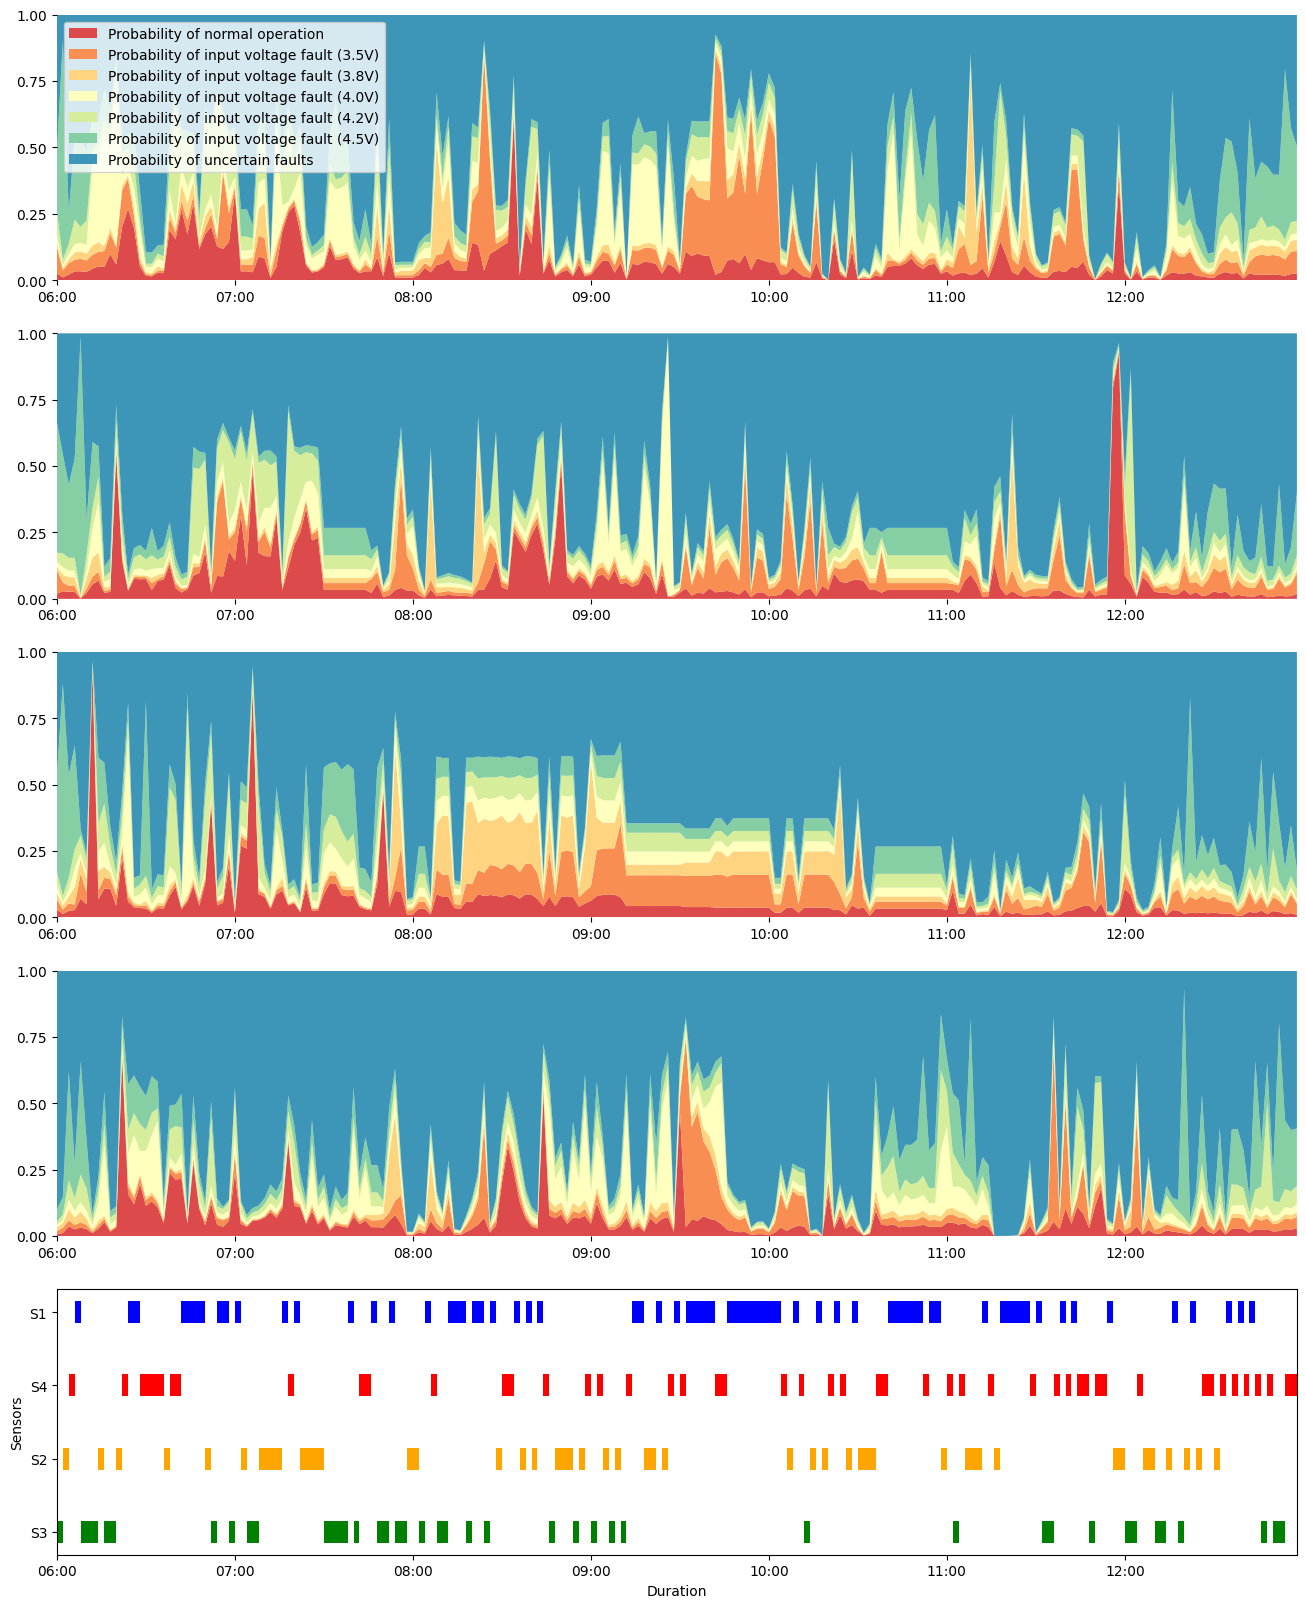

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import numpy as np
import seaborn as sns
import datetime


# # Convert the dates to datetime objects

# Get the number of sensors
num_sensors = 4
sensor_colors = {"S1": "blue", "S2": "orange", "S3": "green", "S4": "red"}

# Create subplots
fig, axs = plt.subplots(num_sensors + 1, 1, figsize=(16, 20), sharex="none")
# Define a color palette with 7 colors
colors = sns.color_palette("Spectral", n_colors=7)
# Plot 100% stacked area for each sensor
for i, ax in enumerate(axs):
    print(i)
    if i < num_sensors:
        key = list(ds_results.keys())[i]
        value = ds_results[key]
        x = value.index
        y = value.values
        # Use iterable unpacking to unpack the columns of y dynamically
        ax.stackplot(indexes[i], *y.T, labels=value.columns, colors=colors)

        # Format x-axis ticks to display only hour and minute
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        # Set rotation for x-axis tick labels
        ax.tick_params(axis="x", rotation=0)

        # Set the number of x-axis ticks to display
        # ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Set interval as desired
        ax.xaxis.set_major_locator(
            mdates.HourLocator(interval=1)
        )  # Set interval as desired

        # Remove x-axis and spines from each subplot
        # ax.xaxis.set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)  # Remove y-axis
        ax.margins(0, 0)  # Remove spaces between subplots
        # Keep the y-axis visible for the last subplot
        if i != len(axs) - 1:
            # ax.xaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            ax.set_ylabel("Y Axis Label")  # Add label for the y-axis
        # Remove title from each subplot
        ax.set_title("")
        # Move the legend to the top outside the subplot
        # ax.legend(loc='upper center', bbox_to_anchor=(0.0, 1.15), ncol=3)

        # Set y-axis tick positions
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    else:
        # Plot the Gantt chart
        for i in range(len(reliability_comparison)):
            start = reliability_comparison.index[i]
            end = (
                reliability_comparison.index[i + 1]
                if i < len(reliability_comparison) - 1
                else reliability_comparison.index[-1]
            )
            # print("Start:\n", start, "\nEnd:\n", end)
            chosen_sensor = reliability_comparison["Highest Reliability"][i]
            ax.barh(
                chosen_sensor,
                end - start,
                left=start,
                height=0.3,
                color=sensor_colors[chosen_sensor],
            )
        # Convert the time index to string format
        time_labels = reliability_comparison.index.strftime('%H:%M')

        # Set the x ticks and labels
        ax.set_xticks(reliability_comparison.index)
        ax.set_xticklabels(time_labels)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set interval as desired

        # Rotate the x tick labels for better visibility
        plt.xticks(rotation=0)
        # Set the x-axis label
        ax.set_xlabel("Duration")

        # Set the y-axis label
        ax.set_ylabel("Sensors")

        # Set the title
        # ax.set_title("Principle sensor selection mechanism based on highest reliability")


# Show legend in the first subplot
axs[0].legend(loc="upper left")
# ax.legend(loc='upper center', bbox_to_anchor=(0.0, 1.15), ncol=1)

# Remove spaces between subplots
plt.subplots_adjust(hspace=0.2)

# Show the plot
plt.show()


plt.show()

### Plot fault identification


In [11]:
from utilities.data_process.continuous_dataflow import continuous_dataflow

dict_sensor_name_to_key = {
    "S1": "20240316_UTS1",
    "S2": "20240316_UTS2",
    "S3": "20240316_UTS3",
    "S4": "20240316_UTS4",
}

cont_data = continuous_dataflow(
    resampled_data,
    reliability_comparison,
    parameter_headers,
    "Highest Reliability",
    dict_sensor_name_to_key,
)
print(cont_data)

Sensor:  S3
time_stamp     1.710482e+09
group_id       1.872000e+03
member_id      1.732110e+05
id             1.732110e+05
humidity       3.450000e+01
temperature    9.200000e+01
pm1.0_atm      1.000000e-02
pm2.5_alt      1.000000e+00
pm10.0_atm     1.100000e+00
Name: 2024-03-15 06:00:00, dtype: float64
Sensor:  S2
time_stamp     1.710483e+09
group_id       1.872000e+03
member_id      1.732120e+05
id             1.732120e+05
humidity       3.400000e+01
temperature    9.200000e+01
pm1.0_atm      2.000000e-02
pm2.5_alt      1.000000e+00
pm10.0_atm     1.050000e+00
Name: 2024-03-15 06:02:00, dtype: float64
Sensor:  S4
time_stamp     1.710483e+09
group_id       1.872000e+03
member_id      1.732100e+05
id             1.732100e+05
humidity       3.250000e+01
temperature    9.250000e+01
pm1.0_atm      4.500000e-02
pm2.5_alt      1.000000e+00
pm10.0_atm     1.100000e+00
Name: 2024-03-15 06:04:00, dtype: float64
Sensor:  S1
time_stamp     1.710483e+09
group_id       1.872000e+03
member_id     

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_596\3664677416.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


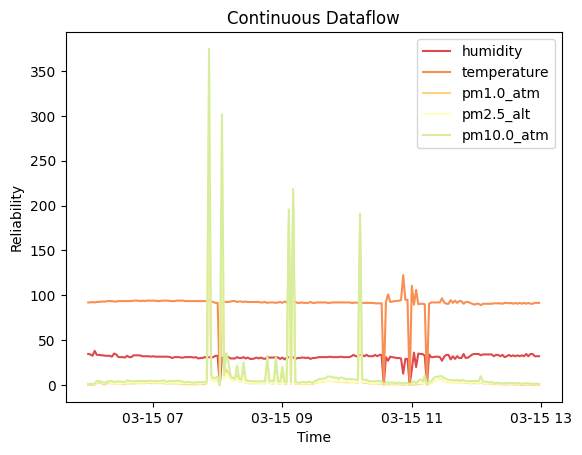

In [21]:
from utilities.plot_functions import plot_line_graph_df

colors = sns.color_palette("Spectral", n_colors=7)
fig_cont_data, axs_cont_data = plot_line_graph_df(
    cont_data,
    y_columns=cont_data.columns,
    title="Continuous Dataflow",
    xlabel="Time",
    ylabel="Reliability",
    color=colors,
)

# Modify the title using the Axes object
# ax.set_title("Probability of normal operation in dependable system")
axs_cont_data.legend(loc="upper right", ncol=1)
axs_cont_data.xaxis.set_major_locator(
        mdates.HourLocator(interval=2)
    ) 
fig.show()
# fig.savefig("modified_figure.png")

### Plot normal operation probability

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_596\3316132903.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


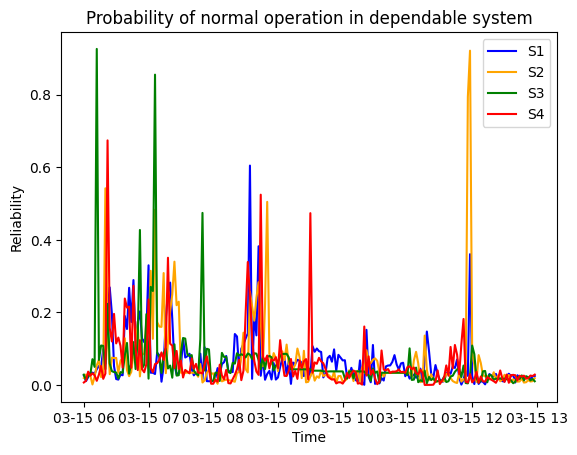

In [13]:
from utilities.plot_functions import *
import matplotlib.pyplot as plt

# Plot the reliability comparison
fig, ax = plot_line_graph_df(
    reliability_comparison,
    y_columns=reliability_comparison.columns[:-1],
    title="Reliability Comparison",
    xlabel="Time",
    ylabel="Reliability",
    color=list(sensor_colors.values()),
)
# Modify the title using the Axes object
ax.set_title("Probability of normal operation in dependable system")
ax.legend(loc="upper right", ncol=1)
fig.show()
fig.savefig("modified_figure.png")

### Plot continuous data flow

In [14]:






# Continuous data flow from data selection mechanism




## Short period fault test

#### Data collection

In [15]:
# Process csv files
csv_dir_v35 = "data/20240319"
csv_file_pattern_v35 = "20240319_UTS{}.csv"
data_processor_v35 = DataProcessor(csv_dir_v35, csv_file_pattern_v35, selected_headers)
csv_data_v35 = data_processor.process_files(start=1, end=5)


time_intervals = [
    {"start": "11-03-2024 14:00:00", "end": "11-03-2024 15:00:00"},
    {"start": "11-03-2024 15:15:00", "end": "11-03-2024 16:00:00"},
    {"start": "11-03-2024 16:10:00", "end": "11-03-2024 17:00:00"},
    {"start": "11-03-2024 17:00:00", "end": "11-03-2024 18:00:00"},
    {"start": "11-03-2024 18:00:00", "end": "11-03-2024 18:30:00"},
]





In [16]:
import numpy as np
import pandas as pd
from DS import DempsterShafer
from process_data import DataProcessor


# Demspter-Shafer

# Feature matrix
# Normal operation from sensors
feat_mat_heat = np.array(
    [
        [42.0, 89.5, 3.6, 3.685, 5.435],
        [15.5, 125.0, 2.7, 2.51, 3.77],
    ]
)

# Faults from sensors


hypotheses = [
    "Probability of normal operation",
    "Probability of overheating fault",
    "Probability of uncertain faults",
]

# csv_file_dir = "data/20240404"
# csv_file_pattern = "202400404_UTS{}.csv"  # Replace with the pattern for your file names
# data_processor = DataProcessor(csv_file_dir, csv_file_pattern, selected_headers)
# csv_data = data_processor.process_files(start=1, end=5)
sampling = np.array(
    [
        [42.5, 87.5, 4.2, 4.6, 7.04],
        [42.5, 87.5, 3.9, 4.475, 7.04],
        [37.0, 99.0, 4.4, 4.335, 6.77],
        [23.5, 111.0, 3.8, 3.505, 5.77],
        [20.0, 115.5, 4.0, 3.635, 5.73],
        [18.0, 119.0, 3.7, 3.355, 5.4],
        [17.0, 121.0, 3.0, 2.745, 4.415],
        [16.0, 123.0, 3.1, 2.535, 4.295],
        [15.0, 124.5, 2.9, 2.75, 4.595],
        [14.5, 125.5, 2.6, 2.515, 3.76],
    ]
)
ds_results = {}
# for sensor, data in prepared_data.items():
#     print("AA", sensor)
#     print(data)
#     ds_results[sensor] = pd.DataFrame()

for row in sampling:
    # sampling = row.reshape((1, 5))
    ds = DempsterShafer(row, feat_mat_heat)
    # print("row:\n", type(row))
    # print("feat:\n", feat_mat_voltage.shape)
    ds.hypothesis_order(hypotheses)
    reliability = ds.result()
    # print(f"Reliability for sampling matrix with 1 samplings: {reliability}")
    # print(f"Reliability for sampling matrix with 1 samplings: {reliability}")
    ds_results = pd.concat(
        [ds_results, reliability], axis=0, ignore_index=True
    )
    
print(reliability)
# print("AB", ds_results['20240316_UTS1'])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
first_key = list(ds_results.keys())[0]
first_value = ds_results[first_key]
print(first_key, first_value)


# Get the number of sensors
num_sensors = 4
sensor_colors = {"S1": "blue", "S2": "orange", "S3": "green", "S4": "red"}

# Create subplots
fig, axs = plt.subplots(num_sensors + 1, 1, figsize=(16, 20), sharex="none")
# Define a color palette with 7 colors
colors = sns.color_palette("Spectral", n_colors=7)
# Plot 100% stacked area for each sensor
for i, ax in enumerate(axs):
    print(i)
    if i < num_sensors:
        key = list(ds_results.keys())[i]
        value = ds_results[key]
        x = value.index
        y = value.values
        # Use iterable unpacking to unpack the columns of y dynamically
        ax.stackplot(indexes[i], *y.T, labels=value.columns, colors=colors)

        # Format x-axis ticks to display only hour and minute
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        # Set rotation for x-axis tick labels
        ax.tick_params(axis="x", rotation=0)

        # Set the number of x-axis ticks to display
        # ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Set interval as desired
        ax.xaxis.set_major_locator(
            mdates.HourLocator(interval=1)
        )  # Set interval as desired

        # Remove x-axis and spines from each subplot
        # ax.xaxis.set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)  # Remove y-axis
        ax.margins(0, 0)  # Remove spaces between subplots
        # Keep the y-axis visible for the last subplot
        if i != len(axs) - 1:
            # ax.xaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            ax.set_ylabel("Y Axis Label")  # Add label for the y-axis
        # Remove title from each subplot
        ax.set_title("")
        # Move the legend to the top outside the subplot
        # ax.legend(loc='upper center', bbox_to_anchor=(0.0, 1.15), ncol=3)

        # Set y-axis tick positions
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

IndexError: list index out of range

In [ ]:
import seaborn as sns

# Define color palettes for each category
color_palettes = {
    "Normal": sns.color_palette("Greens_r", n_colors=5),  # Example color palette for "Normal" category
    "Voltage": sns.color_palette("Oranges_r", n_colors=4),  # Example color palette for "Voltage" category
    "Overheat": ["red"],  # Single color for "Overheat" category
    "Dust": ["blue"],  # Single color for "Dust" category
    "Communication": ["black"],  # Single color for "Communication" category
    "Compound": sns.color_palette("Purples", n_colors=3),  # Example color palette for "Compound" category
    "Uncertain": ["gray"],  # Single color for "Uncertain" category
}

# Map each hypothesis to a color
print(hypotheses)
hypotheses_colors = {}
for category, subcases in hypotheses.items():
    if isinstance(subcases, dict):
        print("Subcases", subcases)
        # If subcases is a dictionary, assign colors to each subcase
        for subcase, code in subcases.items():
            hypotheses_colors[code] = color_palettes[category].pop(0)
    else:
        # If subcases is a single hypothesis, assign color directly
        hypotheses_colors[subcases] = color_palettes[category][0]

# Print the dictionary of hypotheses and their assigned colors
print(hypotheses_colors)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming hypotheses_colors is your dictionary mapping hypotheses to colors
# Example: hypotheses_colors = {'N0': '#1f77b4', 'F_V3_5': '#d62728', ...}

# Prepare labels and colors for plotting
labels = list(hypotheses_colors.keys())
colors = [hypotheses_colors[label] for label in labels]

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar for each hypothesis color
bars = ax.bar(labels, height=1, color=colors)

# Add some customizations
ax.set_xlabel('Hypothesis Codes')
ax.set_yticks([])  # Remove y-axis ticks
ax.set_title('Visualization of Hypothesis Colors')

# Create a legend (optional)
patches = [mpatches.Patch(color=color, label=label) for label, color in hypotheses_colors.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title='Hypotheses')

plt.xticks(rotation=45, ha="right")  # Rotate labels to fit and align right
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()
